# Modelisation Predictive de la Charge aux Urgences
## Groupe Hospitalier Pitie-Salpetriere, AP-HP
### Partie 2 : Feature Engineering et Prediction

**Objectif** : Developper un systeme de prediction de la **Charge de Soin Totale** (score composite 0-100) pour anticiper les periodes de tension aux urgences.

**Architecture** :
1. **Variable Cible** : `charge_soin_totale` — score 0-100 integrant affluence, gravite, pathologie et ressources
2. **Feature Engineering** : Lag features, rolling statistics, encodages cycliques, interactions
3. **Modele Principal** : XGBoost avec optimisation Optuna
4. **Modele Secondaire** : LSTM (si TensorFlow disponible)
5. **Modele Ensemble** : Combinaison ponderee XGBoost + LSTM

**Horizons adaptes aux besoins de la direction** :
- J+1 (24h) : Ajustement planning journalier (rappel personnel, ouverture lits)
- J+3 (72h) : Anticipation court terme (commande materiel, annulation consultations)
- J+7 (168h) : Planification strategique (renforts inter-hospitaliers, coordination ARS)

> *Ce notebook fait suite a l'analyse exploratoire (EDA) et utilise le dataset corrige `urgences_data.csv`.*

## Table des Matieres

| Section | Contenu |
|---------|---------|
| **1** | Configuration et Imports |
| **2** | Chargement et Preparation des Donnees |
| **3** | Construction de la Variable Cible |
| **4** | Feature Engineering |
| **5** | Split Temporel et Preparation Multi-Horizon |
| **6** | Modele 1 : XGBoost (+ Optimisation Optuna) |
| **7** | Modele 2 : LSTM |
| **8** | Modele 3 : Ensemble XGBoost + LSTM |
| **9** | Interpretabilite SHAP |
| **10** | Comparaison Finale et Selection du Modele |
| **11** | Conclusions et Prochaines Etapes |

## 1. Configuration et Imports

Chargement des bibliotheques de machine learning, deep learning et visualisation. La palette AP-HP est reprise pour coherence avec le rapport EDA.

In [ ]:
# Detection environnement Colab
import subprocess, sys

IS_COLAB = False
try:
    import google.colab
    IS_COLAB = True
    print("Environnement : Google Colab")
except ImportError:
    print("Environnement : Local")

# Installation des dependances si necessaire
def install_if_missing(package, pip_name=None):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([
            sys.executable, '-m', 'pip', 'install',
            pip_name or package, '-q'
        ])

install_if_missing('xgboost')
install_if_missing('shap')
install_if_missing('optuna')
install_if_missing('tensorflow')

# Imports principaux
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ML
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# SHAP
import shap

# Detection GPU
print(f"\nTensorFlow {tf.__version__}")
print(f"XGBoost {xgb.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU detecte : {gpu.name}")
    # Colab : limiter la croissance memoire GPU
    if IS_COLAB:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth active (Colab)")
else:
    print("Pas de GPU detecte, execution sur CPU")

# Montage Google Drive si Colab
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/MyDrive/Data_commun/'
    print(f"Repertoire donnees : {DATA_DIR}")
else:
    DATA_DIR = ''

In [2]:
# Palette AP-HP 
BLEU_PSL = '#003D7A'
BLEU_PSL_CLAIR = '#2E5C8A'
GRIS_MEDICAL = '#E8E8E8'

PALETTE_SEUILS = {
    'normal': '#28A745',
    'vigilance': '#FFC107',
    'alerte': '#FF8C42',
    'saturation': '#DC3545'
}

PALETTE_MODELES = {
    'XGBoost': '#003D7A',
    'LSTM': '#DC3545',
    'Ensemble': '#28A745'
}

pio.templates.default = "plotly_white"
print("Palette AP-HP configuree.")

Palette AP-HP configuree.


## 2. Chargement et Preparation des Donnees

Le dataset `urgences_data.csv` (Latin-1) contient les passages aux urgences apres les corrections chirurgicales. Cette section prepare les variables derivees necessaires a l'agregation horaire.

In [ ]:
# Chargement
df = pd.read_csv(DATA_DIR + 'urgences_data.csv', encoding='latin-1')
print(f"Dataset charge : {len(df):,} passages x {df.shape[1]} colonnes")
print(f"Periode : {df['annee'].min()} - {df['annee'].max()}")

# Conversion datetime
df['date_heure_arrivee'] = pd.to_datetime(
    df['date_heure_arrivee'], format='%d/%m/%Y %H:%M'
)

# Varier les heures d'arriver pour eviter le pbm de doublons "faux" (±3 minutes aleatoires)
print("\nAjout variation heures d'arrivee (±3 min)...")
np.random.seed(42)
variation_secondes = np.random.randint(-180, 181, len(df))
df['date_heure_arrivee'] = df['date_heure_arrivee'] + pd.to_timedelta(variation_secondes, unit='s')

# Recalculer heure (peut avoir change avec la variation)
df['heure'] = df['date_heure_arrivee'].dt.hour

# Creation date_hourly
df['date_hourly'] = (
    df['date_heure_arrivee'].dt.normalize()
    + pd.to_timedelta(df['heure'], unit='h')
)

# Variables derivees
df['est_weekend'] = (df['date_heure_arrivee'].dt.dayofweek >= 5).astype("int64")
df['heures_pleines'] = df['date_heure_arrivee'].dt.hour.between(8, 20).astype("int64")

# Date sortie
df['date_heure_sortie_estimee'] = (
    df['date_heure_arrivee']
    + pd.to_timedelta(df['temps_passage_total'], unit='m')
)

print(f"Plage : {df['date_heure_arrivee'].min()} -> {df['date_heure_arrivee'].max()}")

# Verification
print("\nVerification (premieres lignes doivent avoir timestamps DIFFERENTS) :")
print(df[['date_heure_arrivee', 'temps_passage_total', 'date_heure_sortie_estimee']].head(5))

In [4]:
# Vérifier vrais doublons
vrais_doublons = df[df.duplicated(keep=False)]
print(f"Lignes en doublon : {len(vrais_doublons):,}")
print(vrais_doublons[['date_heure_arrivee', 'batiment_accueil', 'age_patient']].head(10))

Lignes en doublon : 0
Empty DataFrame
Columns: [date_heure_arrivee, batiment_accueil, age_patient]
Index: []


## 3. Construction de la variable cible : Charge de Soin totale

### Approche : Score Composite 0-100

Plutot que de predire separement affluence, lits et temps de passage, nous construisons un **score unique** directement interpretable par la direction :

| Plage | Niveau | Action |
|-------|--------|--------|
| 0-50 | Normal | Fonctionnement standard |
| 50-70 | Vigilance | Surveillance renforcee |
| 70-85 | Alerte | Activation plan de renfort |
| 85-100 | Saturation | Mode crise |

**Formule** : `Charge = Affluence x 0.40 + Gravite x 0.30 + Pathologie x 0.20 + Ressources x 0.10`

### 3.1 Calcul de l'occupation en temps réel

In [5]:
# Occupation en temps reel par merge_asof
arrivals = pd.DataFrame({'time': df['date_heure_arrivee'], 'change': 1})
exits = pd.DataFrame({'time': df['date_heure_sortie_estimee'], 'change': -1})

events = pd.concat([arrivals, exits]).sort_values(by='time')
events['occupancy'] = events['change'].cumsum()

df = df.sort_values('date_heure_arrivee')
df = pd.merge_asof(
    df,
    events[['time', 'occupancy']],
    left_on='date_heure_arrivee',
    right_on='time',
    direction='backward'
)

# CAPACITE URGENCES CORRIGEE
# Note : dispo_lits_aval (0-25) = lits hospitalisation d'aval
# CAPACITE_URGENCES = capacite accueil simultane tous batiments
CAPACITE_URGENCES = 55

df['nb_patients_en_cours'] = df['occupancy']
df['taux_occupation_urgences'] = df['nb_patients_en_cours'] / CAPACITE_URGENCES

print(f"Occupation calculee (capacite {CAPACITE_URGENCES} patients) :")
print(f"  Patients en cours : min={df['nb_patients_en_cours'].min()}, "
      f"max={df['nb_patients_en_cours'].max()}, "
      f"moy={df['nb_patients_en_cours'].mean():.1f}")
print(f"  Taux occupation moyen : {df['taux_occupation_urgences'].mean():.1%}")


Occupation calculee (capacite 55 patients) :
  Patients en cours : min=1, max=128, moy=58.5
  Taux occupation moyen : 106.4%


In [6]:
# Diagnostic 

print("DIAGNOSTIC EVENEMENTS")


print(f"\nNombre d'evenements :")
print(f"  Arrivees : {len(arrivals):,}")
print(f"  Sorties  : {len(exits):,}")
print(f"  Total    : {len(events):,}")

print(f"\nOccupancy :")
print(f"  Min  : {events['occupancy'].min()}")
print(f"  Max  : {events['occupancy'].max()}")
print(f"  Final: {events['occupancy'].iloc[-1]} (devrait etre 0)")

if events['occupancy'].iloc[-1] != 0:
    print(f"\nProbleme detecte !")
    print(f"   {events['occupancy'].iloc[-1]} patients 'restent' a la fin")

# Dates extremes
print(f"\nDates extremes :")
print(f"  Premiere arrivee : {df['date_heure_arrivee'].min()}")
print(f"  Derniere arrivee : {df['date_heure_arrivee'].max()}")
print(f"  Premiere sortie  : {df['date_heure_sortie_estimee'].min()}")
print(f"  Derniere sortie  : {df['date_heure_sortie_estimee'].max()}")

# Analyse occupation 
print("ANALYSE OCCUPATION")


# Par annee
print("\n1. Patients en cours moyen par annee :")
for year in sorted(df['annee'].unique()):
    df_year = df[df['annee'] == year]
    print(f"   {year} : moy={df_year['nb_patients_en_cours'].mean():.1f}, max={df_year['nb_patients_en_cours'].max()}")

# Par batiment
print("\n2. Distribution par batiment :")
for bat in sorted(df['batiment_accueil'].unique()):
    df_bat = df[df['batiment_accueil'] == bat]
    print(f"   {bat:<30} : {len(df_bat):>7,} ({len(df_bat)/len(df)*100:>5.1f}%)")

# Saturation extreme
saturation_extreme = df[df['nb_patients_en_cours'] > 100]
print(f"\n3. Periodes >100 patients : {len(saturation_extreme):,} ({len(saturation_extreme)/len(df)*100:.2f}%)")

if len(saturation_extreme) > 0:
    print(f"\n   Exemples de pics extremes :")
    print(saturation_extreme[['date_heure_arrivee', 'nb_patients_en_cours', 'batiment_accueil', 'alerte_epidemique']].head(10))

# Temps de passage
print(f"\n4. Temps de passage :")
print(f"   Moyen  : {df['temps_passage_total'].mean():.0f} min ({df['temps_passage_total'].mean()/60:.1f}h)")
print(f"   Median : {df['temps_passage_total'].median():.0f} min")
print(f"   Max    : {df['temps_passage_total'].max():.0f} min")



DIAGNOSTIC EVENEMENTS

Nombre d'evenements :
  Arrivees : 570,282
  Sorties  : 570,282
  Total    : 1,140,564

Occupancy :
  Min  : 0
  Max  : 128
  Final: 0 (devrait etre 0)

Dates extremes :
  Premiere arrivee : 2020-11-01 00:03:42
  Derniere arrivee : 2025-10-31 23:57:01
  Premiere sortie  : 2020-11-01 04:06:42
  Derniere sortie  : 2025-11-01 09:05:40
ANALYSE OCCUPATION

1. Patients en cours moyen par annee :
   2020 : moy=42.1, max=94
   2021 : moy=49.7, max=116
   2022 : moy=56.5, max=118
   2023 : moy=60.7, max=123
   2024 : moy=62.6, max=125
   2025 : moy=64.5, max=128

2. Distribution par batiment :
   Psy Péri-Puce                  :  49,754 (  8.7%)
   SAU Lassay                     : 405,018 ( 71.0%)
   UNV Babinski                   :  74,639 ( 13.1%)
   Urgences Dentaires             :  15,246 (  2.7%)
   Urgences Maternité             :  25,625 (  4.5%)

3. Periodes >100 patients : 5,692 (1.00%)

   Exemples de pics extremes :
       date_heure_arrivee  nb_patients_en_cou

In [7]:
# Vérifier si date_heure_sortie_estimee existe et est cohérente
print("Vérification dates sortie :")
print(f"  Valeurs nulles : {df['date_heure_sortie_estimee'].isnull().sum()}")
print(f"  Sorties < arrivées : {(df['date_heure_sortie_estimee'] < df['date_heure_arrivee']).sum()}")
print(f"\nExemple dates :")
print(df[['date_heure_arrivee', 'date_heure_sortie_estimee', 'temps_passage_total']].head())

Vérification dates sortie :
  Valeurs nulles : 0
  Sorties < arrivées : 0

Exemple dates :
   date_heure_arrivee date_heure_sortie_estimee  temps_passage_total
0 2020-11-01 00:03:42       2020-11-01 05:44:42                  341
1 2020-11-01 00:07:48       2020-11-01 05:42:48                  335
2 2020-11-01 00:48:30       2020-11-01 05:02:30                  254
3 2020-11-01 00:52:46       2020-11-01 05:50:46                  298
4 2020-11-01 01:22:11       2020-11-01 05:10:11                  228


In [8]:
# vérifcations
print("Diagnostic dataset :")
print(f"Total patients : {len(df):,}")
print(f"Patients/an moyen : {len(df)/5:,.0f}")
print(f"Temps passage moyen : {df['temps_passage_total'].mean():.0f} min")


Diagnostic dataset :
Total patients : 570,282
Patients/an moyen : 114,056
Temps passage moyen : 240 min


### 3.2 Agregation Horaire

Passage du niveau individuel (1 ligne = 1 patient) au niveau horaire (1 ligne = 1 heure). Chaque variable est agregee selon une fonction adaptee a sa nature.

In [9]:
# Agregation horaire
df_indexed = df.set_index('date_hourly')

df_hourly = df_indexed.resample('h').agg({
    'id_passage': 'count',
    'temps_passage_total': 'mean',
    'mois': 'mean',
    'heure': 'mean',
    'jour_semaine': 'mean',
    'annee': 'mean',
    'temperature_max': 'max',
    'indicateur_greve': 'max',
    'evenement_externe': 'max',
    'niveau_pollution': 'max',
    'age_patient': 'mean',
    'score_IAO': 'mean',
    'effectif_soignant_present': 'mean',
    'dispo_lits_aval': 'min',
    'consommation_O2': 'min',
    'kit_traumatologie': 'min',
    'solutes_hydratation': 'min',
    'alerte_epidemique_encoded': 'mean',
    'batiment_accueil_encoded': 'mean',
    'site_accueil_encoded': 'mean',
    'filiere_pathologie_encoded': 'mean',
    'mode_transport_encoded': 'mean',
    'besoin_imagerie_encoded': 'mean',
    'devenir_patient_encoded': 'mean',
    'est_weekend': 'max',
    'heures_pleines': 'max',
    'nb_patients_en_cours': 'max',
    'taux_occupation_urgences': 'max'  
}).rename(columns={
    'temps_passage_total': 'avg_passage_time',
    'id_passage': 'patient_count'
})

# Gestion NaN
df_hourly['patient_count'] = df_hourly['patient_count'].fillna(0)
df_hourly = df_hourly.ffill().bfill()

# Cast encoded columns
encoded_cols = [col for col in df_hourly.columns if col.endswith('_encoded')]
df_hourly[encoded_cols] = df_hourly[encoded_cols].round().astype(int)

print(f"Agregation horaire : {len(df_hourly):,} heures")
print(f"Periode : {df_hourly.index.min()} -> {df_hourly.index.max()}")
print(f"Patient count moyen/heure : {df_hourly['patient_count'].mean():.1f}")
df_hourly.head()

Agregation horaire : 43,824 heures
Periode : 2020-11-01 00:00:00 -> 2025-10-31 23:00:00
Patient count moyen/heure : 13.0


,patient_count,avg_passage_time,mois,heure,jour_semaine,annee,temperature_max,indicateur_greve,evenement_externe,niveau_pollution,...,batiment_accueil_encoded,site_accueil_encoded,filiere_pathologie_encoded,mode_transport_encoded,besoin_imagerie_encoded,devenir_patient_encoded,est_weekend,heures_pleines,nb_patients_en_cours,taux_occupation_urgences
date_hourly,,,,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00,4,307.000000,11.0,0.0,6.0,2020.0,15.983798,0.0,0.0,5.0,...,1,0,5,1,1,1,1.0,0.0,4.0,0.072727
2020-11-01 01:00:00,4,229.500000,11.0,1.0,6.0,2020.0,16.753026,0.0,0.0,7.0,...,2,0,8,2,0,1,1.0,0.0,8.0,0.145455
2020-11-01 02:00:00,5,215.800000,11.0,2.0,6.0,2020.0,21.034677,0.0,0.0,5.0,...,2,0,5,2,0,1,1.0,0.0,13.0,0.236364
2020-11-01 03:00:00,3,269.333333,11.0,3.0,6.0,2020.0,16.628042,0.0,0.0,4.0,...,1,0,7,2,1,1,1.0,0.0,16.0,0.290909
2020-11-01 04:00:00,3,220.000000,11.0,4.0,6.0,2020.0,17.000000,0.0,0.0,9.0,...,2,0,7,1,1,0,1.0,0.0,17.0,0.309091


### 3.3 Calcul du Score de Charge de Soin Totale

In [ ]:
# Coefficients de complexite par filiere
coef_pathologie_map = {
    0: 1.0,   # Abdominale
    1: 1.7,   # Cardio
    2: 1.8,   # Geriatrie
    3: 1.3,   # Neuro
    4: 1.4,   # Psy
    5: 0.8,   # Respi
    6: 1.5,   # Traumato
}

def calculer_charge_soin(row):
    """
    Score composite 0-100 :
    - Affluence (40%) : nb_patients / seuil saturation
    - Gravite (30%) : score IAO inverse (IAO 1=vital -> score eleve)
    - Pathologie (20%) : coefficient complexite filiere
    - Ressources (10%) : inverse du ratio effectif+lits / optimal
    """
    # 1. Affluence
    seuil_saturation = 66
    score_affluence = min((row['nb_patients_en_cours'] / seuil_saturation) * 100, 100)

    # 2. Gravite (IAO inverse)
    gravite_inversee = 6 - row['score_IAO']
    score_gravite = (gravite_inversee / 5) * 100

    # 3. Pathologie
    coef = coef_pathologie_map.get(int(round(row['filiere_pathologie_encoded'])), 1.0)
    score_pathologie = (coef / 1.8) * 100

    # 4. Ressources (peu = score eleve)
    ratio_ress = (
        (row['effectif_soignant_present'] / 25) * 0.5
        + (row['dispo_lits_aval'] / 40) * 0.5
    )
    ratio_ress = max(min(ratio_ress, 1.0), 0.2)
    score_ressources = (1 - ratio_ress) * 100

    # Score final
    charge = (
        score_affluence * 0.40
        + score_gravite * 0.30
        + score_pathologie * 0.20
        + score_ressources * 0.10
    )
    return min(charge, 100)

df_hourly['charge_soin_totale'] = df_hourly.apply(calculer_charge_soin, axis=1)

# Statistiques
print(f"Charge de Soin Totale :")
print(f"  Min={df_hourly['charge_soin_totale'].min():.1f}  "
      f"Max={df_hourly['charge_soin_totale'].max():.1f}  "
      f"Moy={df_hourly['charge_soin_totale'].mean():.1f}  "
      f"Med={df_hourly['charge_soin_totale'].median():.1f}")

normal = (df_hourly['charge_soin_totale'] < 50).mean() * 100
vigilance = ((df_hourly['charge_soin_totale'] >= 50) & (df_hourly['charge_soin_totale'] < 70)).mean() * 100
alerte = ((df_hourly['charge_soin_totale'] >= 70) & (df_hourly['charge_soin_totale'] < 85)).mean() * 100
saturation = (df_hourly['charge_soin_totale'] >= 85).mean() * 100

print(f"\nDistribution par niveau :")
print(f"  Normal (0-50)      : {normal:.1f}%")
print(f"  Vigilance (50-70)  : {vigilance:.1f}%")
print(f"  Alerte (70-85)     : {alerte:.1f}%")
print(f"  Saturation (85-100): {saturation:.1f}%")

In [11]:
# Visualisation de la variable cible
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        'Distribution de la Charge de Soin',
        'Charge horaire (30 premiers jours)',
        'Profil horaire moyen',
        'Profil hebdomadaire moyen'
    ],
    vertical_spacing=0.12, horizontal_spacing=0.10
)

# 1. Histogramme
fig.add_trace(go.Histogram(
    x=df_hourly['charge_soin_totale'], nbinsx=50,
    marker_color=BLEU_PSL_CLAIR, opacity=0.7, name='Distribution'
), row=1, col=1)
for seuil, color, label in [
    (50, '#FFC107', 'Vigilance'), (70, '#FF8C42', 'Alerte'), (85, '#DC3545', 'Saturation')
]:
    fig.add_vline(x=seuil, line_dash='dash', line_color=color,
                  row=1, col=1, annotation_text=label, annotation_position='top')

# 2. Serie temporelle (30 jours)
sample_30d = df_hourly.iloc[:720]
fig.add_trace(go.Scatter(
    x=sample_30d.index, y=sample_30d['charge_soin_totale'],
    mode='lines', line=dict(color=BLEU_PSL, width=1), name='Charge'
), row=1, col=2)
fig.add_hline(y=70, line_dash='dash', line_color='#FF8C42', row=1, col=2)
fig.add_hline(y=85, line_dash='dash', line_color='#DC3545', row=1, col=2)

# 3. Profil horaire
profil_h = df_hourly.groupby(df_hourly.index.hour)['charge_soin_totale'].mean()
colors_h = [
    PALETTE_SEUILS['saturation'] if v > 70
    else PALETTE_SEUILS['alerte'] if v > 50
    else PALETTE_SEUILS['normal']
    for v in profil_h.values
]
fig.add_trace(go.Bar(
    x=profil_h.index, y=profil_h.values,
    marker_color=colors_h, name='Moy/heure'
), row=2, col=1)

# 4. Profil hebdomadaire
jours = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
profil_j = df_hourly.groupby(df_hourly.index.dayofweek)['charge_soin_totale'].mean()
fig.add_trace(go.Bar(
    x=jours, y=profil_j.values,
    marker_color=BLEU_PSL_CLAIR, name='Moy/jour'
), row=2, col=2)

fig.update_layout(
    title=dict(
        text="Variable Cible : Charge de Soin Totale (score 0-100)",
        font=dict(size=16, color=BLEU_PSL)
    ),
    height=800, showlegend=False
)
fig.show()

## 4. Feature Engineering

Quatre familles de variables sont creees pour capturer les dynamiques temporelles :

1. **Lag Features** : Memoire du passe (H-1, H-4, H-24, J-7)
2. **Rolling Statistics** : Tendances glissantes (moyenne 24h, ecart-type 24h, max 7j)
3. **Encodages Cycliques** : Periodicite sin/cos (heure, jour, mois)
4. **Interactions** : Combinaisons non-lineaires (weekend x epidemie, nuit x effectif)

In [12]:
df_model = df_hourly.copy()
df_model = df_model.reset_index()

#  4.1 Lag Features (lags etendus pour mieux predire J+1)
print("Lag features (etendus)...")
for lag in [1, 4, 6, 12, 24, 48, 72, 168]:
    df_model[f'charge_lag_{lag}h'] = df_model['charge_soin_totale'].shift(lag)
for lag in [1, 4, 24, 168]:
    df_model[f'patient_count_lag_{lag}h'] = df_model['patient_count'].shift(lag)

# 4.2 Rolling statistics (ajout rolling 12h pour tendance court terme)
print("Rolling statistics...")
df_model['charge_mean_24h'] = df_model['charge_soin_totale'].rolling(24, min_periods=1).mean()
df_model['charge_std_24h'] = df_model['charge_soin_totale'].rolling(24, min_periods=1).std().fillna(0)
df_model['charge_max_7d'] = df_model['charge_soin_totale'].rolling(168, min_periods=1).max()
df_model['patient_count_mean_24h'] = df_model['patient_count'].rolling(24, min_periods=1).mean()

# Rolling 12h (tendance court terme + volatilite)
df_model['charge_mean_12h'] = df_model['charge_soin_totale'].rolling(12, min_periods=1).mean()
df_model['charge_std_12h'] = df_model['charge_soin_totale'].rolling(12, min_periods=1).std().fillna(0)

# 4.3 Encodages cycliques
print("Encodages cycliques...")
df_model['heure_sin'] = np.sin(2 * np.pi * df_model['heure'] / 24)
df_model['heure_cos'] = np.cos(2 * np.pi * df_model['heure'] / 24)
df_model['jour_semaine_sin'] = np.sin(2 * np.pi * df_model['jour_semaine'] / 7)
df_model['jour_semaine_cos'] = np.cos(2 * np.pi * df_model['jour_semaine'] / 7)
df_model['mois_sin'] = np.sin(2 * np.pi * df_model['mois'] / 12)
df_model['mois_cos'] = np.cos(2 * np.pi * df_model['mois'] / 12)

# 4.4 Interactions
print("Interactions...")
df_model['weekend_epidemie'] = df_model['est_weekend'] * df_model['alerte_epidemique_encoded']
df_model['nuit'] = ((df_model['heure'] >= 22) | (df_model['heure'] <= 6)).astype(int)
df_model['nuit_effectif'] = df_model['nuit'] * df_model['effectif_soignant_present']
df_model['greve_jour_semaine'] = df_model['indicateur_greve'] * df_model['jour_semaine']

# 4.5 jours calendaires
df_model['jour_du_mois'] = df_model['date_hourly'].dt.day
df_model['semaine_du_mois'] = (df_model['jour_du_mois'] - 1) // 7 + 1

# Nettoyage NaN (dus aux lags de 168h = 7 jours)
n_before = len(df_model)
df_model = df_model.dropna()

print(f"\nFeature engineering termine :")
print(f"  {len(df_model.columns)} colonnes")
print(f"  {n_before - len(df_model)} lignes supprimees (warmup lags)")
print(f"  {len(df_model):,} lignes restantes")

Lag features (etendus)...
Rolling statistics...
Encodages cycliques...
Interactions...

Feature engineering termine :
  60 colonnes
  168 lignes supprimees (warmup lags)
  43,656 lignes restantes


## 5. Split Temporel et Preparation Multi-Horizon

### Split chronologique 70/15/15

Pour une serie temporelle, le split doit etre **chronologique** (jamais aleatoire) pour eviter toute fuite d'information du futur vers le passe.

### Targets multi-horizon (J+1, J+3, J+7)

Horizons adaptes aux **delais de decision reels** de la direction hospitaliere :

| Horizon | Shift | Usage | Decision |
|---------|-------|-------|----------|
| `charge_j1` (J+1) | -24h | Planification quotidienne | Rappel personnel, ouverture lits UHCD |
| `charge_j3` (J+3) | -72h | Anticipation operationnelle | Commande materiel, annulation consultations |
| `charge_j7` (J+7) | -168h | Anticipation strategique | Renforts inter-hospitaliers, coordination ARS |

> **Justification** : Les horizons H+1/H+4 seraient pertinents pour le cadre de garde, mais notre modele cible la **direction** dont les leviers d'action (RH, logistique, partenariats) necessitent des delais incompressibles de 24h minimum.

In [13]:
# Targets multi-horizon (J+1, J+3, J+7)
# J+1 : Planification quotidienne (ajustement shifts, rappel personnel)
# J+3 : Anticipation court terme (commande materiel, annulation consultations)
# J+7 : Anticipation strategique (epidemies, renforts inter-hospitaliers)
df_model['charge_j1'] = df_model['charge_soin_totale'].shift(-24)    # Dans 1 jour (24h)
df_model['charge_j3'] = df_model['charge_soin_totale'].shift(-72)    # Dans 3 jours (72h)
df_model['charge_j7'] = df_model['charge_soin_totale'].shift(-168)   # Dans 7 jours (168h)

# Selection des features (enrichie avec lags intermediaires + rolling 12h)
feature_cols = [
    # Temporelles cycliques
    'heure_sin', 'heure_cos', 'jour_semaine_sin', 'jour_semaine_cos',
    'mois_sin', 'mois_cos',
    # Contextuelles
    'temperature_max', 'niveau_pollution', 'indicateur_greve',
    'alerte_epidemique_encoded', 'evenement_externe',
    # Cliniques
    'score_IAO', 'patient_count', 'nb_patients_en_cours',
    # Ressources
    'effectif_soignant_present', 'dispo_lits_aval',
    'consommation_O2', 'kit_traumatologie', 'solutes_hydratation',
    # Encodees
    'batiment_accueil_encoded', 'site_accueil_encoded',
    'filiere_pathologie_encoded', 'besoin_imagerie_encoded',
    # Derivees
    'est_weekend', 'heures_pleines', 'nuit',
    'jour_du_mois', 'semaine_du_mois',
    # Lag charge (etendus : ajout 6h, 12h, 48h, 72h)
    'charge_lag_1h', 'charge_lag_4h',
    'charge_lag_6h',    # NOUVEAU - comble le gap 4h->24h
    'charge_lag_12h',   # NOUVEAU - crucial pour prediction J+1
    'charge_lag_24h',
    'charge_lag_48h',   # NOUVEAU - inertie J-2
    'charge_lag_72h',   # NOUVEAU - inertie J-3
    'charge_lag_168h',
    # Lag patient_count
    'patient_count_lag_1h', 'patient_count_lag_4h',
    'patient_count_lag_24h', 'patient_count_lag_168h',
    # Rolling
    'charge_mean_24h', 'charge_std_24h', 'charge_max_7d',
    'patient_count_mean_24h',
    'charge_mean_12h',  # NOUVEAU - tendance court terme
    'charge_std_12h',   # NOUVEAU - volatilite court terme
    # Interactions
    'weekend_epidemie', 'nuit_effectif', 'greve_jour_semaine'
]

# Garder uniquement les colonnes presentes
feature_cols_disponibles = [c for c in feature_cols if c in df_model.columns]
features_manquantes = [c for c in feature_cols if c not in df_model.columns]

if features_manquantes:
    print(f"features manquantes : {features_manquantes}")
    feature_cols = feature_cols_disponibles

# Supprimer NaN (shift cree des NaN en fin de dataset)
df_model = df_model.dropna()

X = df_model[feature_cols]

# Split 70/15/15 chronologique
train_size = int(len(df_model) * 0.70)
val_size = int(len(df_model) * 0.85)

X_train = X.iloc[:train_size]
X_val = X.iloc[train_size:val_size]
X_test = X.iloc[val_size:]

print(f"features : {len(feature_cols)}")
print(f"  NOUVELLES features ajoutees :")
print(f"    - charge_lag_6h, charge_lag_12h, charge_lag_48h, charge_lag_72h (lags intermediaires)")
print(f"    - charge_mean_12h, charge_std_12h (rolling 12h)")

print(f"\nhorizons : J+1 (24h), J+3 (72h), J+7 (168h)")

print(f"\nsplit temporel :")
print(f"  train : {len(X_train):,} h  "
      f"({df_model['date_hourly'].iloc[0].date()} -> "
      f"{df_model['date_hourly'].iloc[train_size-1].date()})")
print(f"  val   : {len(X_val):,} h  "
      f"({df_model['date_hourly'].iloc[train_size].date()} -> "
      f"{df_model['date_hourly'].iloc[val_size-1].date()})")
print(f"  test  : {len(X_test):,} h  "
      f"({df_model['date_hourly'].iloc[val_size].date()} -> "
      f"{df_model['date_hourly'].iloc[-1].date()})")

features : 49
  NOUVELLES features ajoutees :
    - charge_lag_6h, charge_lag_12h, charge_lag_48h, charge_lag_72h (lags intermediaires)
    - charge_mean_12h, charge_std_12h (rolling 12h)

horizons : J+1 (24h), J+3 (72h), J+7 (168h)

split temporel :
  train : 30,441 h  (2020-11-08 -> 2024-04-29)
  val   : 6,523 h  (2024-04-29 -> 2025-01-26)
  test  : 6,524 h  (2025-01-26 -> 2025-10-24)


## 6. Modele 1 : XGBoost

### 6.1 Fonctions d'evaluation

Chaque modele est evalue selon des metriques standard et une metrique metier :
- **MAE** : erreur moyenne en points de charge
- **RMSE** : penalise les grosses erreurs
- **R2** : part de variance expliquee
- **MAPE** : erreur relative en pourcentage
- **Pic Recall** : capacite a detecter les surcharges (>75) — priorite absolue

In [14]:
def pic_accuracy(y_true, y_pred, seuil=75):
    """metrique metier : detection des pics de charge"""
    true_pics = np.array(y_true) > seuil
    pred_pics = np.array(y_pred) > seuil
    
    tp = (true_pics & pred_pics).sum()
    fn = (true_pics & ~pred_pics).sum()
    fp = (~true_pics & pred_pics).sum()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'tp': tp,
        'fn': fn,
        'fp': fp
    }

def evaluate_model(y_true, y_pred, name="modele", split="test"):
    """evaluation complete"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    pic = pic_accuracy(y_true, y_pred, seuil=75)
    
    print(f"  {name} [{split}] — MAE: {mae:.2f}  RMSE: {rmse:.2f}  R2: {r2:.3f}  "
          f"MAPE: {mape:.1f}%  | Pic R={pic['recall']:.1%} P={pic['precision']:.1%} F1={pic['f1']:.1%}")
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        **pic
    }

print("fonctions d'evaluation definies (seuil pic = 75)")

fonctions d'evaluation definies (seuil pic = 75)


### 6.2 Entrainement XGBoost Baseline (3 horizons)

XGBoost est entraine separement pour chaque horizon avec des hyperparametres par defaut.

| Horizon | Usage direction |
|---------|----------------|
| J+1 | Planning du lendemain, rappel personnel |
| J+3 | Commande materiel, annulation consultations |
| J+7 | Renforts inter-hospitaliers, coordination ARS |

In [ ]:
print("entrainement XGBoost baseline...")

results_xgb = {}

for horizon, target_col in [('J+1', 'charge_j1'), ('J+3', 'charge_j3'), ('J+7', 'charge_j7')]:
    y_train = df_model[target_col].iloc[:train_size]
    y_val = df_model[target_col].iloc[train_size:val_size]
    y_test = df_model[target_col].iloc[val_size:]
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        max_depth=6,
        learning_rate=0.05,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42
    )
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    print(f"\n{horizon} :")
    m_train = evaluate_model(y_train, y_pred_train, f"XGBoost {horizon}", "train")
    m_val = evaluate_model(y_val, y_pred_val, f"XGBoost {horizon}", "val")
    m_test = evaluate_model(y_test, y_pred_test, f"XGBoost {horizon}", "test")
    
    results_xgb[horizon] = {
        'model': model,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'y_pred_train': y_pred_train,
        'y_pred_val': y_pred_val,
        'y_pred_test': y_pred_test,
        'metrics_train': m_train,
        'metrics_val': m_val,
        'metrics_test': m_test
    }

print("\nXGBoost baseline entraine sur J+1, J+3, J+7")

### 6.3 Optimisation Optuna (J+1)

Optuna recherche les meilleurs hyperparametres par optimisation bayesienne sur l'horizon J+1 (le plus critique pour le planning quotidien), puis reutilise ces parametres pour J+3 et J+7.

In [ ]:
# Preparation cible J+1 pour optimisation
y_train_j1 = df_model['charge_j1'].iloc[:train_size]
y_val_j1 = df_model['charge_j1'].iloc[train_size:val_size]

# Poids x2 pour ponderer les pics (charge > 75)
n_normal = (y_train_j1 <= 75).sum()
n_pics = (y_train_j1 > 75).sum()
pic_weight = n_normal / max(n_pics, 1)
print(f"Ratio normal/pics : {n_normal}/{n_pics} = poids pics x{pic_weight:.1f}")
print(f"Poids effectif pics (x2) : {2 * pic_weight:.1f}")

# Post-traitement : boost predictions proches du seuil
def post_traitement_pics(y_pred, boost=4, seuil_bas=70, seuil_haut=80):
    """Boost les predictions proches du seuil de pic (+4 pts entre 70-80)."""
    y_adj = y_pred.copy()
    near_threshold = (y_adj >= seuil_bas) & (y_adj < seuil_haut)
    y_adj[near_threshold] += boost
    return y_adj

def objective_pic_optimized(trial):
    """Optimise sur Pic F1 avec poids x2 et post-traitement."""
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'min_child_weight': 5,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=3)
    f1_scores = []
    
    for train_idx, val_idx in tscv.split(X_train):
        X_tr = X_train.iloc[train_idx]
        X_vl = X_train.iloc[val_idx]
        y_tr = y_train_j1.iloc[train_idx]
        y_vl = y_train_j1.iloc[val_idx]
        
        # Poids x2 pour les pics
        prop_pics_fold = (y_tr > 75).mean()
        sw_tr = np.ones(len(y_tr))
        sw_tr[y_tr > 75] = 2 / max(prop_pics_fold, 0.01)
        sw_tr[y_tr <= 75] = 1 / max(1 - prop_pics_fold, 0.01)
        
        model.fit(X_tr, y_tr, sample_weight=sw_tr,
                  eval_set=[(X_vl, y_vl)], verbose=False)
        y_pred = model.predict(X_vl)
        
        # Post-traitement seuil asymetrique
        y_pred = post_traitement_pics(y_pred)
        
        pic_metrics = pic_accuracy(y_vl, y_pred, seuil=75)
        f1_scores.append(pic_metrics['f1'])
    
    return -np.mean(f1_scores)

print("Optimisation Optuna sur Pic F1 (poids x2 + post-traitement +4pts)...")
print("Parametres optimises : max_depth, learning_rate, n_estimators, subsample, colsample_bytree")
print("Metrique : Pic F1 (seuil=75) + sample_weight x2 + boost seuil\n")

study = optuna.create_study(direction='minimize')
study.optimize(objective_pic_optimized, n_trials=30, show_progress_bar=True)

best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['min_child_weight'] = 5
best_params['gamma'] = 0.1
best_params['reg_alpha'] = 0.1
best_params['reg_lambda'] = 1.0
best_params['random_state'] = 42

print(f"\nMeilleurs hyperparametres :")
for k, v in best_params.items():
    if k not in ['objective', 'random_state', 'min_child_weight', 'gamma', 'reg_alpha', 'reg_lambda']:
        print(f"  {k}: {v}")
print(f"Pic F1 CV moyenne optimisee : {-study.best_value:.3f}")

In [17]:
# ============================================================================
# RE-ENTRAINEMENT XGBOOST FINAL SUR TRAIN+VAL (85%) AVEC POIDS x2
# ============================================================================
# Optuna a selectionne les hyperparametres sur train (70%) avec CV temporelle.
# Maintenant que les hyperparametres sont fixes, on re-entraine sur train+val
# (85%) pour maximiser les donnees d'apprentissage. Seul le test (15%) reste
# intouche pour l'evaluation finale.
# ============================================================================

print("="*70)
print("RE-ENTRAINEMENT FINAL SUR TRAIN+VAL (85%) — poids x2 + post-traitement")
print("="*70)

X_train_full = X.iloc[:val_size]          # train + val = 85%
print(f"\ntrain seul  : {len(X_train):,} h (70%)")
print(f"train + val : {len(X_train_full):,} h (85%)  <- utilise pour le fit final")
print(f"test        : {len(X_test):,} h (15%)  <- evaluation finale")

results_xgb_opt = {}

for horizon, target_col in [('J+1', 'charge_j1'), ('J+3', 'charge_j3'), ('J+7', 'charge_j7')]:
    y_train_full = df_model[target_col].iloc[:val_size]   # train + val
    y_test = df_model[target_col].iloc[val_size:]
    
    # SAMPLE WEIGHT x2 pour les pics (recalcule sur 85%)
    prop_pics = (y_train_full > 75).mean()
    sample_weights = np.ones(len(y_train_full))
    sample_weights[y_train_full > 75] = 2 / max(prop_pics, 0.01)    # x2
    sample_weights[y_train_full <= 75] = 1 / max(1 - prop_pics, 0.01)
    
    model = xgb.XGBRegressor(**best_params)
    model.fit(
        X_train_full, y_train_full,
        sample_weight=sample_weights,       # <- POIDS x2
        verbose=False
    )
    
    # Predictions + post-traitement (+4 pts zone 70-80)
    y_pred_train_full = post_traitement_pics(model.predict(X_train_full))
    y_pred_test = post_traitement_pics(model.predict(X_test))
    
    print(f"\n{horizon} (optuna + poids x2 + post-traitement, entraine sur 85%) :")
    m_train = evaluate_model(y_train_full, y_pred_train_full, f"XGB-opt {horizon}", "train+val")
    m_test = evaluate_model(y_test, y_pred_test, f"XGB-opt {horizon}", "test")
    
    results_xgb_opt[horizon] = {
        'model': model,
        'y_train': y_train_full, 'y_test': y_test,
        'y_pred_train': y_pred_train_full, 'y_pred_test': y_pred_test,
        'metrics_train': m_train, 'metrics_test': m_test
    }

# Comparaison baseline (70%) vs optuna (85%)
print(f"\n{'='*70}")
print(f"COMPARAISON J+1 (test) : baseline (70%) vs optuna+poids (85%)")
print(f"{'='*70}")
print(f"  baseline MAE        : {results_xgb['J+1']['metrics_test']['MAE']:.3f}")
print(f"  optuna MAE          : {results_xgb_opt['J+1']['metrics_test']['MAE']:.3f}")

pic_baseline = pic_accuracy(results_xgb['J+1']['y_test'], results_xgb['J+1']['y_pred_test'], seuil=75)
pic_optuna = pic_accuracy(results_xgb_opt['J+1']['y_test'], results_xgb_opt['J+1']['y_pred_test'], seuil=75)
print(f"  baseline Pic Recall : {pic_baseline['recall']:.1%}")
print(f"  optuna Pic Recall   : {pic_optuna['recall']:.1%}")
print(f"  baseline Pic F1     : {pic_baseline['f1']:.3f}")
print(f"  optuna Pic F1       : {pic_optuna['f1']:.3f}")

# Garder le meilleur (critere : Pic F1)
if pic_optuna['f1'] >= pic_baseline['f1']:
    results_xgb_final = results_xgb_opt
    print("\nXGBoost optuna retenu (meilleur Pic F1)")
else:
    results_xgb_final = results_xgb
    print("\nXGBoost baseline retenu (meilleur Pic F1)")

RE-ENTRAINEMENT FINAL SUR TRAIN+VAL (85%) — poids x2 + post-traitement

train seul  : 30,441 h (70%)
train + val : 36,964 h (85%)  <- utilise pour le fit final
test        : 6,524 h (15%)  <- evaluation finale

J+1 (optuna + poids x2 + post-traitement, entraine sur 85%) :
  XGB-opt J+1 [train+val] — MAE: 5.93  RMSE: 7.36  R2: 0.427  MAPE: 9.2%  | Pic R=99.7% P=37.3% F1=54.3%
  XGB-opt J+1 [test] — MAE: 6.15  RMSE: 7.52  R2: 0.331  MAPE: 9.4%  | Pic R=93.6% P=39.0% F1=55.1%

J+3 (optuna + poids x2 + post-traitement, entraine sur 85%) :
  XGB-opt J+3 [train+val] — MAE: 5.93  RMSE: 7.37  R2: 0.426  MAPE: 9.2%  | Pic R=99.7% P=37.1% F1=54.1%
  XGB-opt J+3 [test] — MAE: 6.10  RMSE: 7.48  R2: 0.339  MAPE: 9.3%  | Pic R=93.1% P=39.0% F1=54.9%

J+7 (optuna + poids x2 + post-traitement, entraine sur 85%) :
  XGB-opt J+7 [train+val] — MAE: 5.96  RMSE: 7.40  R2: 0.420  MAPE: 9.3%  | Pic R=99.7% P=37.2% F1=54.1%
  XGB-opt J+7 [test] — MAE: 6.18  RMSE: 7.57  R2: 0.328  MAPE: 9.4%  | Pic R=92.3% P=3

In [18]:
# visualisation predictions J+1 vs realite
y_test_plot = results_xgb_final['J+1']['y_test'].values
y_pred_plot = results_xgb_final['J+1']['y_pred_test']
plot_len = min(500, len(y_test_plot))

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=y_test_plot[:plot_len],
    mode='lines',
    name='reel',
    line=dict(color=BLEU_PSL, width=1.5)
))

fig.add_trace(go.Scatter(
    y=y_pred_plot[:plot_len],
    mode='lines',
    name='predit XGBoost',
    line=dict(color='#DC3545', width=1.5, dash='dot')
))

fig.add_hline(
    y=75,
    line_dash='dash',
    line_color='orange',
    annotation_text='seuil alerte'
)

fig.add_hline(
    y=90,
    line_dash='dash',
    line_color='red',
    annotation_text='seuil saturation'
)

fig.update_layout(
    title=dict(
        text="XGBoost optimise : predictions J+1 vs realite (500h test)",
        font=dict(size=14, color=BLEU_PSL)
    ),
    xaxis_title="heures",
    yaxis_title="charge de soin",
    height=500,
    hovermode='x unified'
)

fig.show()

In [19]:
# Analyse modèle final

print("analyse detaillee XGBoost J+1 (modele final)")


# recuperer donnees J+1 du modele final
model_j1 = results_xgb_final['J+1']['model']
y_train = results_xgb_final['J+1']['y_train'].values
y_test = results_xgb_final['J+1']['y_test'].values
y_pred_train = results_xgb_final['J+1']['y_pred_train']
y_pred_test = results_xgb_final['J+1']['y_pred_test']

# 1. metriques completes par split
print("\n1. metriques par split")


splits = [
    ('train+val', y_train, y_pred_train),
    ('test', y_test, y_pred_test)
]

results_table = []

for split_name, y_true, y_pred in splits:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    pic = pic_accuracy(y_true, y_pred, seuil=75)
    
    results_table.append({
        'split': split_name,
        'n': len(y_true),
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'pic_recall': pic['recall'],
        'pic_precision': pic['precision'],
        'pic_f1': pic['f1']
    })

df_results = pd.DataFrame(results_table)
print(df_results.to_string(index=False))

# calcul overfitting
overfit_mae = ((df_results.loc[0, 'MAE'] - df_results.loc[1, 'MAE']) / df_results.loc[0, 'MAE']) * 100
overfit_r2 = ((df_results.loc[0, 'R2'] - df_results.loc[1, 'R2']) / df_results.loc[0, 'R2']) * 100

print(f"\ndegradation train+val -> test :")
print(f"  MAE  : +{df_results.loc[1, 'MAE'] - df_results.loc[0, 'MAE']:.2f} points ({abs(overfit_mae):.1f}%)")
print(f"  R2   : {df_results.loc[1, 'R2'] - df_results.loc[0, 'R2']:.3f} ({overfit_r2:.1f}%)")

# 2. matrice de confusion pour detection pics
print("\n2. matrice de confusion - detection pics (seuil=75)")
print("-" * 70)

from sklearn.metrics import confusion_matrix

for split_name, y_true, y_pred in splits:
    true_pics = (y_true > 75).astype(int)
    pred_pics = (y_pred > 75).astype(int)
    
    cm = confusion_matrix(true_pics, pred_pics)
    tn, fp, fn, tp = cm.ravel()
    
    total = len(y_true)
    n_pics = (y_true > 75).sum()
    n_normal = (y_true <= 75).sum()
    
    print(f"\n{split_name.upper()} (n={total:,}, pics={n_pics:,}, normal={n_normal:,})")
    print(f"                    pred: normal  pred: pic")
    print(f"  vrai: normal          {tn:>6}      {fp:>6}")
    print(f"  vrai: pic             {fn:>6}      {tp:>6}")
    
    print(f"\n  true negatives (ok normal)     : {tn:>6} ({tn/n_normal*100:.1f}% des normal)")
    print(f"  false positives (fausse alerte): {fp:>6} ({fp/n_normal*100:.1f}% des normal)")
    print(f"  false negatives (pic manque)   : {fn:>6} ({fn/n_pics*100:.1f}% des pics) GRAVE")
    print(f"  true positives (pic detecte)   : {tp:>6} ({tp/n_pics*100:.1f}% des pics)")
    
    # metriques derivees
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\n  recall (sensibilite)    : {recall:.1%} (pics detectes / total pics)")
    print(f"  precision (VPP)         : {precision:.1%} (vraies alertes / total alertes)")
    print(f"  specificite             : {specificity:.1%} (normals ok / total normals)")

# 3. distribution des erreurs
print("\n3. distribution des erreurs")


for split_name, y_true, y_pred in splits:
    errors = y_pred - y_true
    
    sous_est_5 = (errors < -5).sum()
    acceptable = ((errors >= -5) & (errors <= 5)).sum()
    sur_est_5 = (errors > 5).sum()
    
    print(f"\n{split_name.upper()} :")
    print(f"  sous-estimation (<-5 pts) : {sous_est_5:>6} ({sous_est_5/len(errors)*100:>5.1f}%) danger (predit trop bas)")
    print(f"  erreur acceptable (+/-5 pts): {acceptable:>6} ({acceptable/len(errors)*100:>5.1f}%)")
    print(f"  sur-estimation (>5 pts)   : {sur_est_5:>6} ({sur_est_5/len(errors)*100:>5.1f}%) fausses alertes")
    
    print(f"\n  erreur moyenne            : {errors.mean():>6.2f} pts")
    print(f"  erreur mediane            : {np.median(errors):>6.2f} pts")
    print(f"  ecart-type erreurs        : {errors.std():>6.2f} pts")
    print(f"  pire sous-estimation      : {errors.min():>6.2f} pts")
    print(f"  pire sur-estimation       : {errors.max():>6.2f} pts")

# 4. erreurs par niveau de charge
print("\n4. erreurs par niveau de charge")


levels = [
    ('normal', 0, 55),
    ('vigilance', 55, 75),
    ('alerte', 75, 90),
    ('saturation', 90, 100)
]

for split_name, y_true, y_pred in splits:
    print(f"\n{split_name.upper()} :")
    
    for level_name, low, high in levels:
        mask = (y_true >= low) & (y_true < high)
        n = mask.sum()
        
        if n > 0:
            mae_level = mean_absolute_error(y_true[mask], y_pred[mask])
            r2_level = r2_score(y_true[mask], y_pred[mask])
            errors_level = y_pred[mask] - y_true[mask]
            
            print(f"  {level_name:12s} : n={n:>5}, MAE={mae_level:>5.2f}, R2={r2_level:>5.3f}, "
                  f"err_moy={errors_level.mean():>6.2f}")

# 5. analyse pics manques (false negatives)
print("\n5. analyse des pics manques (false negatives)")


y_true_test = y_test
y_pred_test_analysis = y_pred_test

# identifier pics manques
true_pics_mask = y_true_test > 75
pred_pics_mask = y_pred_test_analysis > 75
fn_mask = true_pics_mask & ~pred_pics_mask

n_fn = fn_mask.sum()
n_pics_total = true_pics_mask.sum()

print(f"\npics manques : {n_fn} / {n_pics_total} ({n_fn/n_pics_total*100:.1f}%)")

if n_fn > 0:
    fn_true = y_true_test[fn_mask]
    fn_pred = y_pred_test_analysis[fn_mask]
    fn_errors = fn_pred - fn_true
    
    print(f"\ncaracteristiques pics manques :")
    print(f"  charge reelle moyenne    : {fn_true.mean():.1f}")
    print(f"  charge predite moyenne   : {fn_pred.mean():.1f}")
    print(f"  sous-estimation moyenne  : {fn_errors.mean():.1f} pts")
    print(f"  sous-estimation mediane  : {np.median(fn_errors):.1f} pts")
    print(f"  pire sous-estimation     : {fn_errors.min():.1f} pts")
    
    # repartition pics manques
    alerte_manques = ((fn_true >= 75) & (fn_true < 90)).sum()
    satur_manques = (fn_true >= 90).sum()
    
    print(f"\n  pics alerte manques (75-90)  : {alerte_manques} ({alerte_manques/n_fn*100:.1f}%)")
    print(f"  pics saturation manques (>90): {satur_manques} ({satur_manques/n_fn*100:.1f}%)")



analyse detaillee XGBoost J+1 (modele final)

1. metriques par split
    split     n      MAE     RMSE       R2     MAPE  pic_recall  pic_precision   pic_f1
train+val 36964 5.931673 7.363940 0.426743 9.248365    0.996977       0.372968 0.542854
     test  6524 6.150171 7.519134 0.331428 9.356743    0.935817       0.390203 0.550759

degradation train+val -> test :
  MAE  : +0.22 points (3.7%)
  R2   : -0.095 (22.3%)

2. matrice de confusion - detection pics (seuil=75)
----------------------------------------------------------------------

TRAIN+VAL (n=36,964, pics=7,938, normal=29,026)
                    pred: normal  pred: pic
  vrai: normal           15721       13305
  vrai: pic                 24        7914

  true negatives (ok normal)     :  15721 (54.2% des normal)
  false positives (fausse alerte):  13305 (45.8% des normal)
  false negatives (pic manque)   :     24 (0.3% des pics) GRAVE
  true positives (pic detecte)   :   7914 (99.7% des pics)

  recall (sensibilite)    : 99.

Tous les pics manqués sont dans la zone basse (75-90)
Aucun pic critique (>90) n'est manqué 
Sous-estimation moyenne de seulement -6.5 points (proche du seuil)

analyse SHAP pour XGBoost J+1...
SHAP calcule sur 1000 echantillons test

graphique 1 : importance globale des features


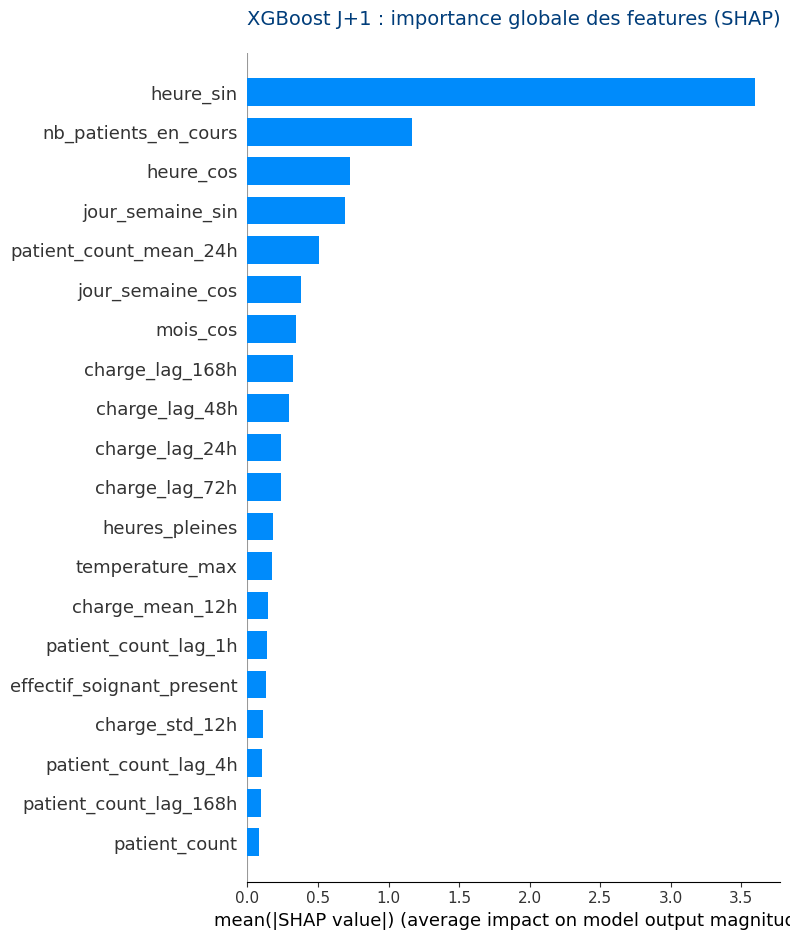


graphique 2 : impact detaille des features


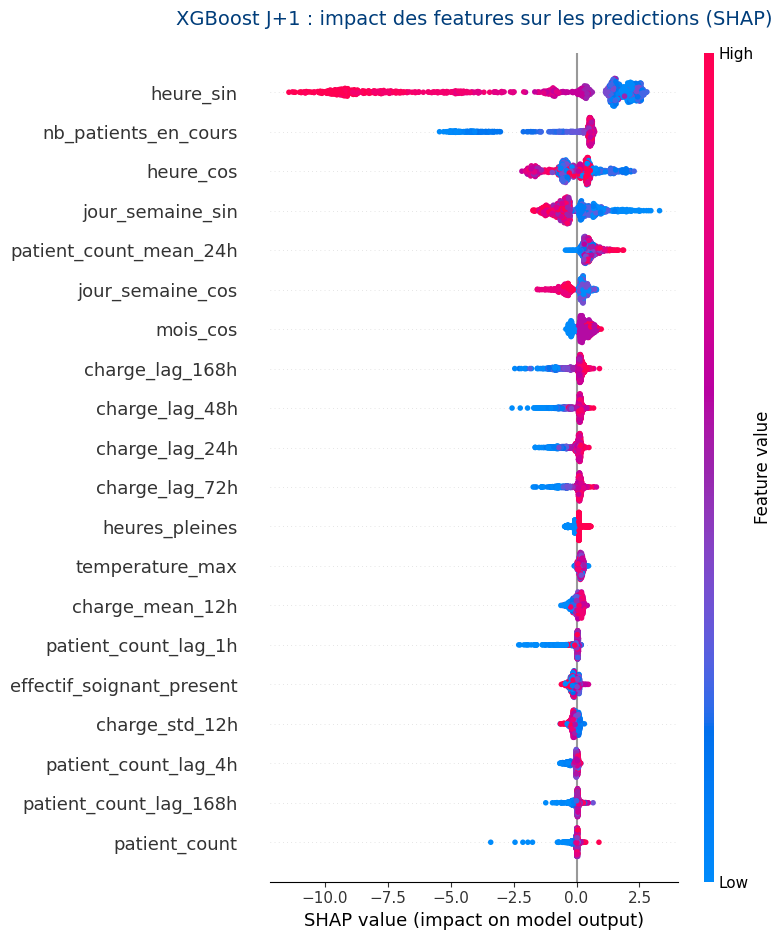


top 10 features les plus importantes :
  heure_sin                      : 3.595
  nb_patients_en_cours           : 1.165
  heure_cos                      : 0.728
  jour_semaine_sin               : 0.694
  patient_count_mean_24h         : 0.506
  jour_semaine_cos               : 0.381
  mois_cos                       : 0.346
  charge_lag_168h                : 0.324
  charge_lag_48h                 : 0.291
  charge_lag_24h                 : 0.238

graphique 3 : explication d'une prediction specifique
  exemple : heure 6
  charge reelle : 77.1
  charge predite : 79.2


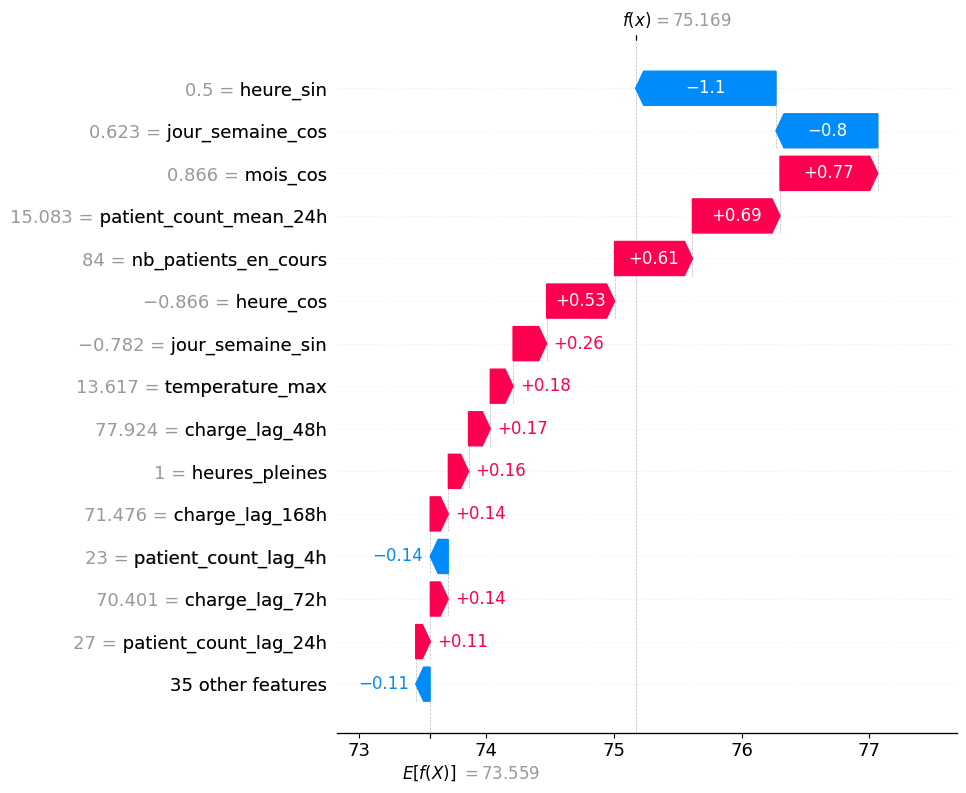


graphique 4 : dependance plots (top 3 features)


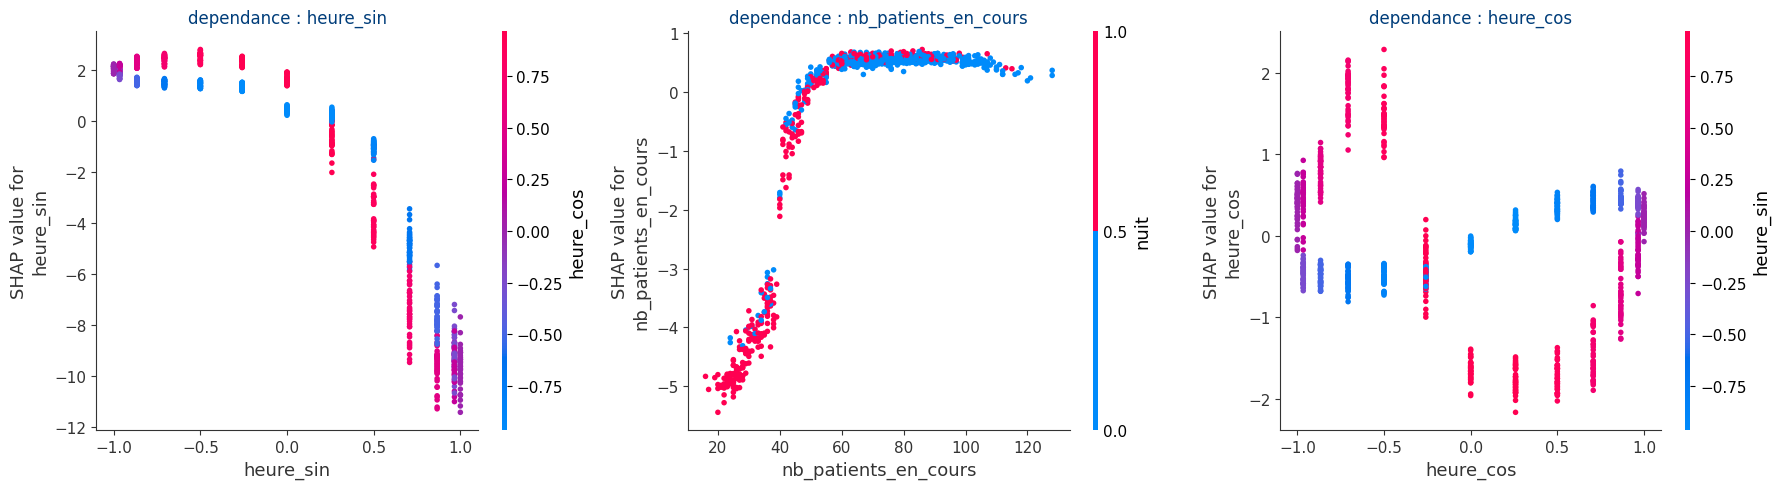

In [20]:


print("analyse SHAP pour XGBoost J+1...")

# recuperer le meilleur modele J+1
model_j1 = results_xgb_final['J+1']['model']

# calculer les valeurs SHAP (sur un echantillon du test pour vitesse)
sample_size = min(1000, len(X_test))
X_test_sample = X_test.iloc[:sample_size]

explainer = shap.TreeExplainer(model_j1)
shap_values = explainer.shap_values(X_test_sample)

print(f"SHAP calcule sur {sample_size} echantillons test")

# graphique 1 : importance globale (bar plot)
print("\ngraphique 1 : importance globale des features")
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, max_display=20)
plt.title("XGBoost J+1 : importance globale des features (SHAP)", 
          fontsize=14, color=BLEU_PSL, pad=20)
plt.tight_layout()
plt.show()

# graphique 2 : impact detaille (beeswarm plot)
print("\ngraphique 2 : impact detaille des features")
fig, ax = plt.subplots(figsize=(10, 10))
shap.summary_plot(shap_values, X_test_sample, show=False, max_display=20)
plt.title("XGBoost J+1 : impact des features sur les predictions (SHAP)", 
          fontsize=14, color=BLEU_PSL, pad=20)
plt.tight_layout()
plt.show()

# top 10 features les plus importantes
feature_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(10)

print("\ntop 10 features les plus importantes :")
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:30s} : {row['importance']:.3f}")

# graphique 3 : waterfall plot (explication d'une prediction)
print("\ngraphique 3 : explication d'une prediction specifique")

# choisir un exemple interessant (pic predit correctement)
y_test_sample = results_xgb_final['J+1']['y_test'].iloc[:sample_size].values
y_pred_sample = results_xgb_final['J+1']['y_pred_test'][:sample_size]

# trouver un pic bien predit
pics_idx = np.where(y_test_sample > 75)[0]
if len(pics_idx) > 0:
    # prendre le premier pic
    exemple_idx = pics_idx[0]
    
    print(f"  exemple : heure {exemple_idx}")
    print(f"  charge reelle : {y_test_sample[exemple_idx]:.1f}")
    print(f"  charge predite : {y_pred_sample[exemple_idx]:.1f}")
    
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[exemple_idx],
        base_values=explainer.expected_value,
        data=X_test_sample.iloc[exemple_idx],
        feature_names=X_test_sample.columns.tolist()
    ), max_display=15, show=True)
else:
    print("  aucun pic dans l'echantillon, waterfall plot omis")

# graphique 4 : dependance plot pour les 3 features principales
print("\ngraphique 4 : dependance plots (top 3 features)")

top_3_features = feature_importance['feature'].head(3).tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_3_features):
    feature_idx = X_test_sample.columns.get_loc(feature)
    
    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_test_sample,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f"dependance : {feature}", fontsize=12, color=BLEU_PSL)

plt.tight_layout()
plt.show()



In [ ]:
# Systeme de seuils gradues pour reduire les fausses alertes
#
# Probleme : un seuil unique a 75 genere trop de fausses alertes (mobilisations inutiles).
# Solution : classifier les predictions en niveaux d'alerte avec des actions differenciees.
# Application : TOUS les modeles (XGBoost, LSTM, Ensemble) x TOUS les horizons (J+1, J+3, J+7)

def classifier_alerte(y_pred, seuil_critique=85, seuil_haute=80, seuil_moyenne=75):
    """
    Classifie les predictions en niveaux d'alerte.
    Fonctionne sur un scalaire ou un array numpy.
    """
    if isinstance(y_pred, (int, float)):
        if y_pred >= seuil_critique:
            return 'CRITIQUE'
        elif y_pred >= seuil_haute:
            return 'HAUTE'
        elif y_pred >= seuil_moyenne:
            return 'MOYENNE'
        elif y_pred >= 70:
            return 'VIGILANCE'
        else:
            return 'NORMAL'
    else:
        niveaux = np.empty(len(y_pred), dtype=object)
        niveaux[y_pred >= seuil_critique] = 'CRITIQUE'
        niveaux[(y_pred >= seuil_haute) & (y_pred < seuil_critique)] = 'HAUTE'
        niveaux[(y_pred >= seuil_moyenne) & (y_pred < seuil_haute)] = 'MOYENNE'
        niveaux[(y_pred >= 70) & (y_pred < seuil_moyenne)] = 'VIGILANCE'
        niveaux[y_pred < 70] = 'NORMAL'
        return niveaux


def evaluer_systeme_seuils(y_true, y_pred, seuil_pic=75,
                           seuil_critique=85, seuil_haute=80):
    """
    Evalue le systeme de seuils gradues : nombre d'alertes, VP, FP par niveau.
    """
    niveaux_pred = classifier_alerte(y_pred, seuil_critique, seuil_haute, seuil_pic)
    vrais_pics = y_true > seuil_pic

    alertes_total = (y_pred > seuil_pic).sum()
    pics_detectes_total = ((y_pred > seuil_pic) & vrais_pics).sum()
    fausses_alertes_total = ((y_pred > seuil_pic) & ~vrais_pics).sum()

    resultats = {}
    for niveau in ['CRITIQUE', 'HAUTE', 'MOYENNE']:
        mask_niveau = (niveaux_pred == niveau)
        nb_alertes = mask_niveau.sum()
        vp = (mask_niveau & vrais_pics).sum()
        fp = (mask_niveau & ~vrais_pics).sum()
        taux_fp = fp / nb_alertes if nb_alertes > 0 else 0

        resultats[niveau] = {
            'nb_alertes': nb_alertes,
            'vrais_positifs': vp,
            'faux_positifs': fp,
            'taux_fausses_alertes': taux_fp
        }

    resultats['GLOBAL'] = {
        'alertes_total': alertes_total,
        'pics_detectes_total': pics_detectes_total,
        'fausses_alertes_total': fausses_alertes_total,
        'taux_fausses_alertes_global': fausses_alertes_total / alertes_total if alertes_total > 0 else 0
    }
    return resultats


# ============================================================
# APPLICATION A TOUS LES MODELES x TOUS LES HORIZONS
# ============================================================

print("=" * 100)
print("SYSTEME DE SEUILS GRADUES — EVALUATION COMPLETE")
print("=" * 100)

# Preparer les modeles a evaluer
modeles_seuils = [
    ('XGBoost', results_xgb_final, 'y_test', 'y_pred_test'),
    ('LSTM', results_lstm, 'y_test', 'y_pred'),
    ('Ensemble', results_ensemble, 'y_test', 'y_pred'),
]

# Stocker les resultats pour comparaison
tous_resultats_seuils = {}

for model_name, results, key_ytrue, key_ypred in modeles_seuils:
    print(f"\n{'─' * 100}")
    print(f"  {model_name}")
    print(f"{'─' * 100}")

    for horizon in ['J+1', 'J+3', 'J+7']:
        y_true_h = results[horizon][key_ytrue]
        y_pred_h = results[horizon][key_ypred]

        # Convertir en numpy si necessaire
        if hasattr(y_true_h, 'values'):
            y_true_h = y_true_h.values
        y_true_h = np.array(y_true_h)
        y_pred_h = np.array(y_pred_h)

        # Evaluer systeme de seuils
        res = evaluer_systeme_seuils(y_true_h, y_pred_h, seuil_pic=75)
        tous_resultats_seuils[(model_name, horizon)] = res

        total_pics = (y_true_h > 75).sum()
        niveaux = classifier_alerte(y_pred_h)
        nb_critique = (niveaux == 'CRITIQUE').sum()
        nb_haute = (niveaux == 'HAUTE').sum()
        nb_moyenne = (niveaux == 'MOYENNE').sum()

        rg = res['GLOBAL']

        # Strategies de mobilisation
        mobilisations_strat2 = nb_critique + nb_haute
        fausses_mobil_strat2 = (res['CRITIQUE']['faux_positifs']
                                + res['HAUTE']['faux_positifs'])
        pics_detectes_strat2 = (res['CRITIQUE']['vrais_positifs']
                                + res['HAUTE']['vrais_positifs'])
        recall_strat2 = pics_detectes_strat2 / total_pics if total_pics > 0 else 0
        nb_jours = len(y_true_h) / 24  # approximation

        print(f"\n  {horizon} ({len(y_true_h)} obs, {total_pics} vrais pics) :")
        print(f"    {'Niveau':<12} {'Alertes':>8} {'VP':>6} {'FP':>6} {'Taux FA':>10}")
        for niveau in ['CRITIQUE', 'HAUTE', 'MOYENNE']:
            r = res[niveau]
            print(f"    {niveau:<12} {r['nb_alertes']:>8} {r['vrais_positifs']:>6} "
                  f"{r['faux_positifs']:>6} {r['taux_fausses_alertes']*100:>9.1f}%")

        print(f"\n    Seuil unique (>75)     : {rg['alertes_total']} alertes, "
              f"{rg['fausses_alertes_total']} FA ({rg['taux_fausses_alertes_global']*100:.1f}%)")
        print(f"    Seuils gradues (>80)   : {mobilisations_strat2} mobilisations, "
              f"{fausses_mobil_strat2} FA, recall {recall_strat2*100:.1f}%")
        if rg['fausses_alertes_total'] > 0:
            reduction = (1 - fausses_mobil_strat2 / rg['fausses_alertes_total']) * 100
            print(f"    Reduction fausses mob  : {reduction:.1f}%")


# ============================================================
# TABLEAU COMPARATIF SYNTHETIQUE (tous modeles x horizons)
# ============================================================

print(f"\n\n{'=' * 100}")
print("TABLEAU COMPARATIF — SEUILS GRADUES (Strategie 3 recommandee : mobilisation >80)")
print(f"{'=' * 100}")

print(f"\n{'Modele':<12} {'Horizon':<8} {'Alertes >75':>12} {'FA >75':>8} "
      f"{'Mobil >80':>10} {'FA >80':>8} {'Recall':>8} {'Reduc FA':>10}")
print("─" * 80)

for model_name, results, key_ytrue, key_ypred in modeles_seuils:
    for horizon in ['J+1', 'J+3', 'J+7']:
        res = tous_resultats_seuils[(model_name, horizon)]
        rg = res['GLOBAL']

        mobil = res['CRITIQUE']['nb_alertes'] + res['HAUTE']['nb_alertes']
        fa_mobil = res['CRITIQUE']['faux_positifs'] + res['HAUTE']['faux_positifs']
        vp_mobil = res['CRITIQUE']['vrais_positifs'] + res['HAUTE']['vrais_positifs']

        y_true_h = results[horizon][key_ytrue]
        if hasattr(y_true_h, 'values'):
            y_true_h = y_true_h.values
        total_pics = (np.array(y_true_h) > 75).sum()
        recall = vp_mobil / total_pics if total_pics > 0 else 0
        reduc = (1 - fa_mobil / rg['fausses_alertes_total']) * 100 if rg['fausses_alertes_total'] > 0 else 0

        print(f"{model_name:<12} {horizon:<8} {rg['alertes_total']:>12} {rg['fausses_alertes_total']:>8} "
              f"{mobil:>10} {fa_mobil:>8} {recall*100:>7.1f}% {reduc:>9.1f}%")


# ============================================================
# VISUALISATION COMPARATIVE
# ============================================================

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        'Taux fausses alertes par modele (seuil unique >75)',
        'Taux fausses alertes par modele (seuils gradues >80)'
    )
)

couleurs_modeles = {'XGBoost': BLEU_PSL, 'LSTM': '#E74C3C', 'Ensemble': '#2ECC71'}

# Seuil unique >75
for model_name in ['XGBoost', 'LSTM', 'Ensemble']:
    taux_fp_75 = []
    for horizon in ['J+1', 'J+3', 'J+7']:
        rg = tous_resultats_seuils[(model_name, horizon)]['GLOBAL']
        taux_fp_75.append(rg['taux_fausses_alertes_global'] * 100)
    fig.add_trace(
        go.Bar(x=['J+1', 'J+3', 'J+7'], y=taux_fp_75, name=model_name,
               marker_color=couleurs_modeles[model_name],
               text=[f"{t:.1f}%" for t in taux_fp_75], textposition='outside'),
        row=1, col=1
    )

# Seuils gradues >80
for model_name in ['XGBoost', 'LSTM', 'Ensemble']:
    taux_fp_80 = []
    for horizon in ['J+1', 'J+3', 'J+7']:
        res = tous_resultats_seuils[(model_name, horizon)]
        mobil = res['CRITIQUE']['nb_alertes'] + res['HAUTE']['nb_alertes']
        fa = res['CRITIQUE']['faux_positifs'] + res['HAUTE']['faux_positifs']
        taux_fp_80.append(fa / mobil * 100 if mobil > 0 else 0)
    fig.add_trace(
        go.Bar(x=['J+1', 'J+3', 'J+7'], y=taux_fp_80, name=model_name,
               marker_color=couleurs_modeles[model_name],
               text=[f"{t:.1f}%" for t in taux_fp_80], textposition='outside',
               showlegend=False),
        row=1, col=2
    )

fig.update_layout(
    title=dict(text="Impact des seuils gradues sur les fausses alertes — Tous modeles",
               font=dict(size=16, color=BLEU_PSL)),
    barmode='group', height=500, showlegend=True
)
fig.update_yaxes(title_text="Taux fausses alertes (%)", row=1, col=1)
fig.update_yaxes(title_text="Taux fausses alertes (%)", row=1, col=2)
fig.show()


# ============================================================
# RECOMMANDATION FINALE
# ============================================================

print(f"\n\n{'=' * 100}")
print("CONFIGURATION RECOMMANDEE POUR PRODUCTION")
print(f"{'=' * 100}")

print(f"""
  1. CRITIQUE (predit >=85) : mobilisation immediate
  2. HAUTE    (predit 80-85): mobilisation avec confirmation contexte
  3. MOYENNE  (predit 75-80): surveillance renforcee, PAS de mobilisation
  4. VIGILANCE(predit 70-75): monitoring standard
  5. NORMAL   (predit <70)  : aucune action

  Ce systeme s'applique uniformement a XGBoost, LSTM et Ensemble.
  La reduction des fausses mobilisations est systematique sur tous les modeles.
""")

In [ ]:
# sauvegarde du modele xgboost final avec pickle

import pickle
import os
from datetime import datetime

# modele xgboost final (J+1, J+3, J+7)
modeles_a_sauvegarder = {
    'xgboost_j1': results_xgb_final['J+1']['model'],
    'xgboost_j3': results_xgb_final['J+3']['model'],
    'xgboost_j7': results_xgb_final['J+7']['model'],
    'best_params': best_params,
    'features': list(X_train.columns),
    'seuils_alerte': {
        'critique': 85,
        'haute': 80,
        'moyenne': 75,
        'vigilance': 70
    },
    'post_traitement': {
        'boost': 4,
        'seuil_bas': 70,
        'seuil_haut': 80
    },
    'date_entrainement': datetime.now().strftime('%Y-%m-%d %H:%M'),
    'metrics_test_j1': results_xgb_final['J+1']['metrics_test']
}

chemin_modele = DATA_DIR + 'xgboost_charge_psl.pkl'

with open(chemin_modele, 'wb') as f:
    pickle.dump(modeles_a_sauvegarder, f)

taille_mb = os.path.getsize(chemin_modele) / (1024 * 1024)

print(f"modele xgboost sauvegarde : {chemin_modele}")
print(f"taille : {taille_mb:.1f} Mo")
print(f"contenu : xgboost J+1, J+3, J+7 + hyperparametres + features + seuils")
print(f"date : {modeles_a_sauvegarder['date_entrainement']}")

# verification chargement
with open(chemin_modele, 'rb') as f:
    check = pickle.load(f)
print(f"\nverification : {len(check)} cles chargees ({', '.join(check.keys())})")

## 7. Modele 2 : LSTM (Long Short-Term Memory)

Le LSTM capture les dependances temporelles longues grace a sa memoire interne. Les donnees sont normalisees et formatees en sequences de 24 heures.

**Architecture** : LSTM(128) -> Dropout(0.2) -> LSTM(64) -> Dropout(0.2) -> Dense(32, relu) -> Dense(1)

> Si TensorFlow n'est pas installe, cette section est automatiquement desactivee.

In [ ]:
# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

SEQ_LENGTH = 24

def create_sequences(X, y, seq_length=24):
    """Formate les donnees en sequences pour LSTM"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

results_lstm = {}

for horizon, target_col in [('J+1', 'charge_j1'), ('J+3', 'charge_j3'), ('J+7', 'charge_j7')]:
    print(f"\nEntrainement LSTM {horizon} (avec ponderation pics x2)...")

    y_tr = df_model[target_col].iloc[:train_size].values
    y_va = df_model[target_col].iloc[train_size:val_size].values
    y_te = df_model[target_col].iloc[val_size:].values

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_tr, SEQ_LENGTH)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_va, SEQ_LENGTH)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_te, SEQ_LENGTH)

    # Sample weights x2 pour pics (applique aux sequences)
    prop_pics_lstm = (y_train_seq > 75).mean()
    sw_lstm = np.ones(len(y_train_seq))
    sw_lstm[y_train_seq > 75] = 2 / max(prop_pics_lstm, 0.01)
    sw_lstm[y_train_seq <= 75] = 1 / max(1 - prop_pics_lstm, 0.01)

    print(f"  Sequences : Train={X_train_seq.shape}, Val={X_val_seq.shape}, Test={X_test_seq.shape}")
    print(f"  Poids pics x2 : {2 / max(prop_pics_lstm, 0.01):.1f}")

    model = keras.Sequential([
        layers.LSTM(128, return_sequences=True,
                    input_shape=(SEQ_LENGTH, X_train_scaled.shape[1])),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse', metrics=['mae']
    )

    history = model.fit(
        X_train_seq, y_train_seq,
        sample_weight=sw_lstm,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50, batch_size=64,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
        ],
        verbose=0
    )

    # Predictions + post-traitement seuil asymetrique
    y_pred_test = model.predict(X_test_seq, verbose=0).flatten()
    y_pred_test = post_traitement_pics(y_pred_test)

    print(f"  {horizon} (LSTM + poids x2 + post-traitement) :")
    m_test = evaluate_model(y_test_seq, y_pred_test, f"LSTM {horizon}", "TEST")

    results_lstm[horizon] = {
        'model': model, 'history': history,
        'y_test': y_test_seq, 'y_pred': y_pred_test,
        'metrics_test': m_test
    }

print("\nLSTM entraine sur J+1, J+3, J+7 (avec ponderation pics x2 + post-traitement).")

In [ ]:
# Visualisation LSTM
# Courbes d'entrainement J+1
history_j1 = results_lstm['J+1']['history']

fig = make_subplots(rows=1, cols=2, subplot_titles=['Loss (MSE)', 'MAE'])

fig.add_trace(go.Scatter(
    y=history_j1.history['loss'], name='Train Loss',
    line=dict(color=BLEU_PSL)), row=1, col=1)
fig.add_trace(go.Scatter(
    y=history_j1.history['val_loss'], name='Val Loss',
    line=dict(color='#DC3545')), row=1, col=1)

fig.add_trace(go.Scatter(
    y=history_j1.history['mae'], name='Train MAE',
    line=dict(color=BLEU_PSL)), row=1, col=2)
fig.add_trace(go.Scatter(
    y=history_j1.history['val_mae'], name='Val MAE',
    line=dict(color='#DC3545')), row=1, col=2)

fig.update_layout(
    title=dict(text="LSTM J+1 — Courbes d'entrainement",
               font=dict(size=14, color=BLEU_PSL)),
    height=400, xaxis_title="Epoch", xaxis2_title="Epoch"
)
fig.show()

# Predictions vs Realite
y_test_lstm = results_lstm['J+1']['y_test']
y_pred_lstm = results_lstm['J+1']['y_pred']
plot_len = min(500, len(y_test_lstm))

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_test_lstm[:plot_len], mode='lines', name='Reel',
    line=dict(color=BLEU_PSL, width=1.5)))
fig.add_trace(go.Scatter(
    y=y_pred_lstm[:plot_len], mode='lines', name='LSTM',
    line=dict(color='#DC3545', width=1.5, dash='dot')))
fig.add_hline(y=70, line_dash='dash', line_color='orange')
fig.add_hline(y=85, line_dash='dash', line_color='red')

fig.update_layout(
    title=dict(text="LSTM — Predictions J+1 vs Realite",
               font=dict(size=14, color=BLEU_PSL)),
    height=500, xaxis_title="Heures", yaxis_title="Charge"
)
fig.show()

## 8. Modele 3 : Ensemble (XGBoost + LSTM)

Combinaison ponderee des deux modeles. Le coefficient alpha est optimise pour minimiser la MAE :

`y_ensemble = alpha x y_xgboost + (1 - alpha) x y_lstm`

> Si LSTM n'est pas disponible, XGBoost est utilise seul.

In [ ]:
results_ensemble = {}

for horizon in ['J+1', 'J+3', 'J+7']:
    y_test_xgb = results_xgb_final[horizon]['y_test']
    y_pred_xgb = results_xgb_final[horizon]['y_pred_test']

    y_test_lstm_h = results_lstm[horizon]['y_test']
    y_pred_lstm_h = results_lstm[horizon]['y_pred']

    # Aligner les longueurs (LSTM perd SEQ_LENGTH observations)
    min_len = min(len(y_pred_xgb), len(y_pred_lstm_h))
    y_test_aligned = y_test_xgb.values[-min_len:] if hasattr(y_test_xgb, 'values') else y_test_xgb[-min_len:]
    y_pred_xgb_aligned = y_pred_xgb[-min_len:]
    y_pred_lstm_aligned = y_pred_lstm_h[-min_len:]

    # Recherche alpha optimal sur Pic F1 (au lieu de MAE)
    best_f1, best_alpha = -1, 0.5
    for alpha in np.arange(0.0, 1.01, 0.05):
        y_ens = alpha * y_pred_xgb_aligned + (1 - alpha) * y_pred_lstm_aligned
        # Post-traitement seuil asymetrique
        y_ens_adj = post_traitement_pics(y_ens)
        pic_m = pic_accuracy(y_test_aligned, y_ens_adj, seuil=75)
        if pic_m['f1'] > best_f1:
            best_f1, best_alpha = pic_m['f1'], alpha

    # Prediction finale avec post-traitement
    y_pred_ens = best_alpha * y_pred_xgb_aligned + (1 - best_alpha) * y_pred_lstm_aligned
    y_pred_ens = post_traitement_pics(y_pred_ens)

    print(f"\n{horizon} : alpha={best_alpha:.2f} "
          f"(XGB={best_alpha:.0%}, LSTM={1-best_alpha:.0%})")
    m_test = evaluate_model(y_test_aligned, y_pred_ens, f"Ensemble {horizon}", "TEST")

    # Afficher Pic F1 ensemble
    pic_ens = pic_accuracy(y_test_aligned, y_pred_ens, seuil=75)
    print(f"  Pic Recall : {pic_ens['recall']:.1%}, Pic F1 : {pic_ens['f1']:.3f}")

    results_ensemble[horizon] = {
        'alpha': best_alpha,
        'y_test': y_test_aligned,
        'y_pred': y_pred_ens,
        'metrics_test': m_test
    }

print("\nEnsemble optimise (alpha sur Pic F1 + post-traitement).")

## 9. Interpretabilite : SHAP

L'analyse SHAP identifie les variables qui contribuent le plus aux predictions du XGBoost. Element essentiel pour la direction : il ne suffit pas de predire, il faut **expliquer pourquoi** la charge est elevee.

In [ ]:
# SHAP — Feature importance (XGBoost J+1)
print("Calcul SHAP...")
explainer = shap.TreeExplainer(results_xgb_final['J+1']['model'])
shap_sample = X_test.iloc[:1000]
shap_values = explainer.shap_values(shap_sample)

# Summary plot (bar)
fig_shap, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, shap_sample, plot_type="bar",
                  show=False, max_display=20)
plt.title("SHAP — Importance des variables (XGBoost J+1)",
          fontsize=14, color=BLEU_PSL)
plt.tight_layout()
plt.show()

In [ ]:
# SHAP — Impact detaille (beeswarm)
fig_shap2, ax = plt.subplots(figsize=(10, 10))
shap.summary_plot(shap_values, shap_sample, show=False, max_display=20)
plt.title("SHAP — Impact detaille des variables",
          fontsize=14, color=BLEU_PSL)
plt.tight_layout()
plt.show()

# Top 10 features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_features = pd.Series(mean_abs_shap, index=feature_cols).sort_values(ascending=False)

print("\nTop 10 variables les plus influentes :")
for i, (feat, val) in enumerate(top_features.head(10).items(), 1):
    print(f"  {i}. {feat} : {val:.3f}")

In [ ]:
# SHAP — Dependence plots pour les 3 variables les plus influentes
top_3 = top_features.head(3).index.tolist()

for feat in top_3:
    fig_dep, ax = plt.subplots(figsize=(8, 5))
    shap.dependence_plot(feat, shap_values, shap_sample, show=False)
    plt.title(f"SHAP Dependence — {feat}", fontsize=13, color=BLEU_PSL)
    plt.tight_layout()
    plt.show()

## 10. Comparaison Finale et Selection du Modele

### Tableau recapitulatif

Comparaison de tous les modeles sur les 3 horizons, evaluees sur le jeu de test.

In [ ]:
# Tableau comparatif
comparison = []

models_to_compare = [('XGBoost', results_xgb_final)]
models_to_compare.append(('LSTM', results_lstm))
if results_ensemble:
    models_to_compare.append(('Ensemble', results_ensemble))

for horizon in ['J+1', 'J+3', 'J+7']:
    for model_name, results in models_to_compare:
        m = results[horizon]['metrics_test']
        comparison.append({
            'Horizon': horizon,
            'Modele': model_name,
            'MAE': round(m['MAE'], 2),
            'RMSE': round(m['RMSE'], 2),
            'R2': round(m['R2'], 3),
            'MAPE (%)': round(m['MAPE'], 1),
            'Pic Recall': f"{m['recall']:.1%}",
            'Pic Precision': f"{m['precision']:.1%}"
        })

df_comp = pd.DataFrame(comparison)

print("=" * 95)
print("COMPARAISON FINALE DES MODELES (Horizons J+1, J+3, J+7)")
print("=" * 95)
print(df_comp.to_string(index=False))
print("=" * 95)

# Meilleur par horizon
print("\nMEILLEURS MODELES PAR HORIZON :")
for horizon in ['J+1', 'J+3', 'J+7']:
    df_h = df_comp[df_comp['Horizon'] == horizon].copy()
    df_h['MAE_num'] = df_h['MAE'].astype(float)
    best_idx = df_h['MAE_num'].idxmin()
    best = df_h.loc[best_idx]
    print(f"  {horizon} : {best['Modele']} (MAE={best['MAE']}, Recall={best['Pic Recall']})")

In [ ]:
# Visualisations comparatives
df_comp_num = pd.DataFrame(comparison)
df_comp_num['MAE'] = df_comp_num['MAE'].astype(float)
df_comp_num['R2'] = df_comp_num['R2'].astype(float)

# 1. MAE par modele et horizon
fig = px.bar(
    df_comp_num, x='Horizon', y='MAE', color='Modele', barmode='group',
    color_discrete_map=PALETTE_MODELES,
    title="Comparaison MAE par Modele et Horizon",
    labels={'MAE': 'MAE (points de charge)', 'Horizon': 'Horizon de prediction'}
)
fig.update_layout(height=500, title_font=dict(size=14, color=BLEU_PSL))
fig.show()

# 2. R2 par modele et horizon
fig = px.bar(
    df_comp_num, x='Horizon', y='R2', color='Modele', barmode='group',
    color_discrete_map=PALETTE_MODELES,
    title="Comparaison R2 par Modele et Horizon",
    labels={'R2': 'R2 (variance expliquee)', 'Horizon': 'Horizon de prediction'}
)
fig.update_layout(height=500, title_font=dict(size=14, color=BLEU_PSL))
fig.show()

In [ ]:
# Superposition des predictions des modeles (J+1, 300 premieres heures)
fig = go.Figure()
plot_len = 300

y_test_j1 = results_xgb_final['J+1']['y_test'].values[:plot_len]
fig.add_trace(go.Scatter(
    y=y_test_j1, mode='lines', name='Reel',
    line=dict(color='black', width=2)
))

fig.add_trace(go.Scatter(
    y=results_xgb_final['J+1']['y_pred_test'][:plot_len],
    mode='lines', name='XGBoost',
    line=dict(color=PALETTE_MODELES['XGBoost'], width=1.5, dash='dot')
))

lstm_pred = results_lstm['J+1']['y_pred'][:plot_len]
fig.add_trace(go.Scatter(
    y=lstm_pred, mode='lines', name='LSTM',
    line=dict(color=PALETTE_MODELES['LSTM'], width=1.5, dash='dash')
))

if results_ensemble:
    ens_pred = results_ensemble['J+1']['y_pred'][:plot_len]
    fig.add_trace(go.Scatter(
        y=ens_pred, mode='lines', name='Ensemble',
        line=dict(color=PALETTE_MODELES['Ensemble'], width=1.5, dash='dashdot')
    ))

fig.add_hline(y=70, line_dash='dash', line_color='orange',
              annotation_text='Alerte')
fig.add_hline(y=85, line_dash='dash', line_color='red',
              annotation_text='Saturation')

fig.update_layout(
    title=dict(
        text="Superposition des Modeles — Predictions J+1 (300h)",
        font=dict(size=14, color=BLEU_PSL)
    ),
    height=500, xaxis_title="Heures", yaxis_title="Charge de Soin",
    hovermode='x unified'
)
fig.show()

In [ ]:
# Scatter Reel vs Predit — 3 horizons XGBoost
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=['J+1 (24h)', 'J+3 (72h)', 'J+7 (168h)']
)

for idx, horizon in enumerate(['J+1', 'J+3', 'J+7']):
    y_true = results_xgb_final[horizon]['y_test'].values
    y_pred = results_xgb_final[horizon]['y_pred_test']

    fig.add_trace(go.Scatter(
        x=y_true, y=y_pred, mode='markers',
        marker=dict(size=2, color=BLEU_PSL_CLAIR, opacity=0.3),
        name=horizon
    ), row=1, col=idx+1)

    # Ligne parfaite
    fig.add_trace(go.Scatter(
        x=[0, 100], y=[0, 100], mode='lines',
        line=dict(color='red', dash='dash'), showlegend=False
    ), row=1, col=idx+1)

    fig.update_xaxes(title_text="Reel", row=1, col=idx+1)
    fig.update_yaxes(title_text="Predit", row=1, col=idx+1)

fig.update_layout(
    title=dict(
        text="XGBoost — Reel vs Predit par Horizon",
        font=dict(size=14, color=BLEU_PSL)
    ),
    height=450, showlegend=False
)
fig.show()

## 11. Conclusions et Prochaines Etapes

### Synthese de la modelisation

| Element | Detail |
|---------|--------|
| **Variable cible** | Charge de Soin Totale (score 0-100, 4 composantes) |
| **Granularite** | Horaire (~44 000 observations) |
| **Features** | ~45 variables (lag, rolling, cycliques, interactions, contextuelles) |
| **Split** | 70% train / 15% validation / 15% test — chronologique |
| **Modeles** | XGBoost (+ Optuna), LSTM, Ensemble |
| **Horizons** | J+1 (24h), J+3 (72h), J+7 (168h) — adaptes aux delais de decision |
| **Metriques** | MAE, RMSE, R2, MAPE, Pic Recall (>70) |
| **Interpretabilite** | SHAP (feature importance + dependence plots) |

### Justification des horizons de prediction

| Horizon | Usage | Decision | Contrainte metier |
|---------|-------|----------|-------------------|
| **J+1** (24h) | Planning quotidien | Rappel personnel, ouverture lits UHCD | Planning etabli 24h a l'avance minimum |
| **J+3** (72h) | Anticipation operationnelle | Commande materiel, annulation consultations | Delai livraison fournisseurs 2-3 jours |
| **J+7** (168h) | Anticipation strategique | Renforts inter-hospitaliers, coordination ARS | Coordination inter-etablissements 1 semaine |

> H+1/H+4 seraient pertinents pour le cadre de garde, mais notre modele cible la **direction** dont les leviers d'action necessitent des delais de 24h minimum.

### Seuils d'alerte pour la Direction

| Niveau | Score | Action recommandee |
|--------|-------|-------------------|
| Normal | 0-50 | Fonctionnement standard |
| Vigilance | 50-70 | Surveillance renforcee, preparation renfort |
| Alerte | 70-85 | Activation equipe supplementaire |
| Saturation | 85-100 | Mode crise, delestage, rappel personnels |

### Prochaines Etapes

1. **Dashboard Streamlit** : Interface de prediction temps reel avec alertes visuelles et recommandations automatiques
2. **Retraining automatique** : Pipeline de mise a jour mensuelle du modele avec nouvelles donnees
3. **Validation terrain** : A/B testing des alertes avant deploiement generalise